**Author: Eric Zeng**

**Email: bz866@nyu.edu**

**Note:**

The file has examples to do factor vectorization by PAC and N-S smoothing after straight-line interpolation

- Get the 249 days of 2018 US Treasury yield curve from FRED as sample data

- Compute the covariance matrix of day-over-day arithmetic changes in yields

- Compute the principal components of this covariance matrix

- Eigenvectors & eigenvalues analysis 


- Straight-line interpolation between the 11 given maturities

- Generate the 360 levels of that yield curve for each maturity month from 1 month to 30 years. 

- Fit the parameters of a Nelson-Siegel curve to this so that the sum of the absolute differences between each month’s straight-line curve rate and the Nelson-Siegel rate is minimized.

- Graph the original curve and the Nelson-Siegel curve. 


In [1]:
import qrbook_funcs as qf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#FRED codes for US Treasury constant maturity rates
seriesnames=['DGS1MO','DGS3MO','DGS6MO','DGS1','DGS2','DGS3','DGS5','DGS7','DGS10','DGS20','DGS30']
maturities=qf.TenorsFromNames(seriesnames)

dates, prices=qf.GetFREDMatrix(seriesnames, startdate='2018-01-02', enddate='2018-12-31')
#remove no-data periods
nobs, t = len(dates), 0
while t<nobs:
    if all(np.isnan(prices[t])):
        del prices[t]
        del dates[t]
        nobs -= 1
    else:
        t += 1

**Note: PCA Step by Step**

Ref: http://www.sthda.com/english/wiki/print.php?id=206

The formula to compute the covariance matrix: 
$$ C = \frac{1}{n-1}\Sigma^{n}_{i=1}(X_{i} - \bar{X})(X_{i} - \bar{X})^{T} $$

**The aim of PCA is to minimize this distortions and to summarize the essential information in the data**

**Interpretation of Covariance Matrix**
1. The diagonal elements are the variances of the different variables. A large diagonal values correspond to strong signal.
2. The off-diagonal values are the covariances between variables. They reflect distortions in the data (noise, redundancy, …). Large off-diagonal values correspond to high distortions in our data.

** Minimize the Distortion **
1. The off-diagonal values are different from zero. This indicates the presence of redundancy in the data. In other words, there is a certain amount of correlation between variables.

** Steps **
1. Prepare the data
    - centered: substract the mean
    - scaling: divide by the standard deviation
2. Calculate the Covariance matrix
3. Calculate the eigen values and the eigen vectors
4. Choose principle components, e.t. the number of eigen values or eigen vectors
5. project the data to the eigen vectors and get the new dataset

$$ C\nu = \lambda \nu$$
where 
- $C$: the covariance matrix 
- $\lambda$: Eigen values 
- $\nu$: Eigen vectors

In [3]:
# Prices nested lists as numpy array
arrPricesDxS = np.asarray(prices)
arrPricesSxD = arrPricesDxS.T

# dfPriceDxS = pd.DataFrame(data=arrPricesDxS, index=dates, columns=seriesnames)
# dfPriceDxS.head(3)
dfPriceSxD = pd.DataFrame(data=arrPricesSxD, index=seriesnames, columns=dates)
dfPriceSxD.head(3)

,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-08,2018-01-09,2018-01-10,2018-01-11,2018-01-12,2018-01-16,...,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-24,2018-12-26,2018-12-27,2018-12-28,2018-12-31
DGS1MO,1.29,1.29,1.28,1.27,1.30,1.27,1.31,1.32,1.31,1.33,...,2.36,2.35,2.35,2.42,2.41,2.42,2.41,2.43,2.39,2.44
DGS3MO,1.44,1.41,1.41,1.39,1.45,1.44,1.42,1.43,1.43,1.45,...,2.40,2.39,2.40,2.39,2.39,2.45,2.44,2.41,2.40,2.45
DGS6MO,1.61,1.59,1.60,1.58,1.60,1.60,1.59,1.58,1.59,1.63,...,2.54,2.53,2.54,2.55,2.54,2.52,2.54,2.49,2.48,2.56


In [4]:
# day-to-day arithmetic changes in yields
arrPricesSxDDiff = np.diff(arrPricesSxD, axis=1)
# Covariance matrix of day-over-day arithmetic changes in yields
covPricesSxDDiff = np.cov(arrPricesSxDDiff)

In [5]:
# eigenvalues & eigenvectors
(eigVals, eigVecs) = np.linalg.eig(covPricesSxDDiff)

In [6]:
# Top 3 principle components
print("Top 3 pinciple components:")
print()
for i in range(0,3):
    print("#{} eigen values: {}".format(i+1, eigVals[i]))
    print()
    
# percentage of the trace from the first 3 PC's 
pctTop3PC = sum(eigVals[0:3]) / sum(eigVals)
print("The Percentatge of the first 3 PC's: {}%".format(pctTop3PC.real*100))

Top 3 pinciple components:

#1 eigen values: 0.0071846216520539165

#2 eigen values: 0.0010950746039160974

#3 eigen values: 0.0006944384291891291

The Percentatge of the first 3 PC's: 90.25296103123884%


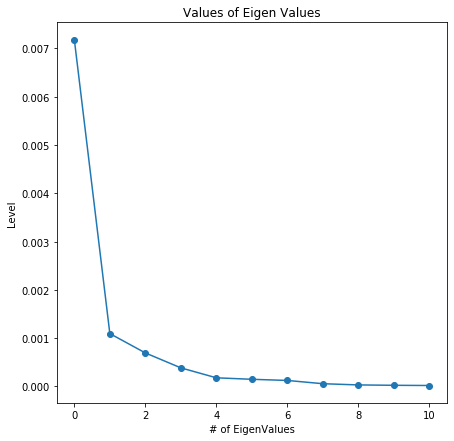

In [7]:
# Levels of Eigen Values
figEigenVals = plt.figure(figsize=(7,7))
ax1 = plt.axes()
ax1.plot(np.arange(0, 11), eigVals[0:11].real, '-o')
ax1.set_xlabel("# of EigenValues")
ax1.set_ylabel("Level")
plt.title('Values of Eigen Values')
plt.show()

In [8]:
# Ref: http://sebastianraschka.com/Articles/2014_pca_step_by_step.html
# Test Cv = lambda * v
try:
    for i in range(0, len(eigVals)):
        eigVec = eigVecs[:, i].reshape(1, len(eigVals)).T
        # C * v = \lambda * v
        np.testing.assert_array_almost_equal(covPricesSxDDiff.dot(eigVec), eigVals[i] * eigVec,
                                             decimal=6, err_msg='', verbose=True)
        # <eigenVec, eigenVec> = 1
        np.testing.assert_array_almost_equal(eigVec.reshape(1,len(eigVals)).dot(eigVec), 1.0,
                                             decimal=6, err_msg='', verbose=True)
    print("Cv = \lambda * v checking successful.") # success
except:
    raise ValueError
    
# Project to the first three principle components 
arrPricesSx3PCDiff = covPricesSxDDiff.dot(eigVecs[:, 0:3].reshape(3, len(eigVals)).T.real)
dfPricesSx3PCDiff = pd.DataFrame(arrPricesSx3PCDiff, index=seriesnames, columns=["PCOne", "PCTwo", "PCThree"])
dfPricesSx3PCDiff.head(5)

Cv = \lambda * v checking successful.


,PCOne,PCTwo,PCThree
DGS1MO,-0.000223,0.000375,0.000086
DGS3MO,-0.000387,0.000249,0.000082
DGS6MO,-0.000291,0.000329,0.000150
DGS1,-0.000213,0.000749,0.000094
DGS2,-0.000359,0.001431,0.000110


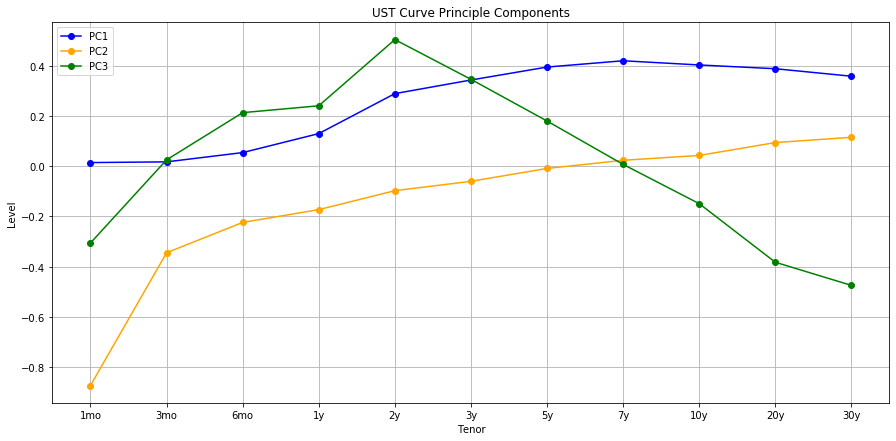

In [9]:
# Graph the first 3 eigenvectors
xTicks = ['1mo', '3mo', '6mo', '1y', '2y', '3y', '5y', '7y', '10y', '20y', '30y']
Xs = np.arange(0, len(seriesnames))

fig = plt.figure(figsize=(15,7))
ax = plt.axes()
ax.plot(Xs, eigVecs[:, 0], '-o', color='blue', label='PC1')
ax.plot(Xs, eigVecs[:, 1], '-o', color='orange', label='PC2')
ax.plot(Xs, eigVecs[:, 2], '-o', color='green', label='PC3')
# ax.set_xticklabels(xTicks)
plt.xticks(Xs, xTicks)
ax.set_xlabel('Tenor')
ax.set_ylabel('Level')
plt.title('UST Curve Principle Components')
plt.legend()
plt.grid(True)
plt.show()


- **PC1: Level**

The first factor in Q3 is different with the first factor of Frye on shift. In Frye, the first factor forms roughly a flat line centered around 0.4. In Q3, the first factor forms a upward-sloping blue line. The shift in the yield curve increases with longer maturity.  

However, the first factor is always above 0, which is same as the first factor in Frye. This means although the shift in the yield curve increases with longer maturity, shifts are to the same direction. 

- **PV2: Steepness**

The second factor in Q3 is similar to the second factor in Frye. The second factor corresponds to a 'twist' or change of slope of the yield curve. In short-term. Rates in short-term move in one direction while rates in long-term move in the other direction. 

In Q3, the direction of the 'twist' between 1 month to 5 years is different with the direction of it between 5 years to 30 years. In Frye, the direction of the 'twist' between 3 months to 3 years is different with the direction of it between 3 years to 30 years.

- **PC3: Curvature**

The third factor in Q3 is also similar to the third factor in Frye. The third factor corresponds to the 'bowing' of the yield curve. Super short rates and relatively long rates move in to one direction; the intermediate rates move in the other direction. 

In Q3, the super short rates(1 to 3 month) and relatively long rates(7 to 30 years) move in one direction; the intermidiate rates(3 months to 7 years) move in the other direction. In Frye, the relatively short rates(3 to 6 months) and the relatively long rates(5 to 30 years) move in one direction; the intermediate rates(1 to 5 years) move in the other direction. 

#### Interpolation & NS-smoothing

In [10]:
# 2018-12-31 US Treasury yield curve 
yieldCurve20181231 = dfPriceSxD[['2018-12-31']]

# Convert matrities to months for interpolation
# e.g. DGS2Y => 24 months
months = [1, 3, 6, 12, 24, 36, 60, 84, 120, 240, 360] # convert months and years to months 
yieldCurve20181231AsMth = pd.DataFrame(yieldCurve20181231.values, 
                                      index=months, 
                                      columns=yieldCurve20181231.columns)
yieldCurve20181231AsMth

,2018-12-31
1,2.44
3,2.45
6,2.56
12,2.63
24,2.48
36,2.46
60,2.51
84,2.59
120,2.69
240,2.87


In [11]:
# Setup of interpolation
expectedMonths = np.arange(1, 361, 1) # each maturity month from 1 month to 30 years
xp = np.asarray(yieldCurve20181231AsMth.index)
fp = np.ndarray.flatten(yieldCurve20181231AsMth.values)

# interpolation
yiledsInterp = np.interp(expectedMonths, xp, fp)
# format as dataframe
yieldCurve20181231Interp = pd.DataFrame(data=yiledsInterp, 
                                        index=expectedMonths,  # Months
                                        columns=yieldCurve20181231.columns)
yieldCurve20181231Interp.head(10)

,2018-12-31
1,2.440000
2,2.445000
3,2.450000
4,2.486667
5,2.523333
6,2.560000
7,2.571667
8,2.583333
9,2.595000
10,2.606667


**Note:**

The Nelson-Siegel's smoothing technique is used to create a continuous curve. If $r(0,f)$ is the smoothed yield(r=rate) for a zero-coupon bond starting now (time t=0) and going to some final maturity time $t=f$ in the future, then NS smoothed version of $r(0,f)$ is: 

$$ r(0,f) = \beta_{0} + \beta_{1}\frac{\tau}{f}(1 - \exp{(-\frac{f}{\tau})}) + \beta_{2}\frac{\tau}{f}(1 - \exp{-\frac{f}{\tau}}(1 + \frac{f}{\tau})) $$

While later examples of this class of smoothing techniques use more parameters, the Nelson-Siegel version uses the four parameters $\beta_0, \beta_1, \beta_2,$ and $\tau$, which can be fitted to observed input yields $y_1,\dots,y_k$ at maturity times $t_1,\dots,t_k$ to provide in most cases a good fit. These parameters have straightforward intuitive explanations:

- As $f\rightarrow\infty$, all terms except for $\beta_0$ approach zero, so $\beta_0$ is the yield level at the long end of the curve.
- As $f\rightarrow 0$, r(0,f) approaches $\beta_0+\beta_1$, so $\beta_0$ is the opposite of the slope between the yield at the short end of the curve and the yield at the long end of the curve.
- $\beta_2$ determines yield levels in the middle (“belly”) of the curve.
- $\tau$ controls how fast the levels transition from short end to belly to long end.


#### NS smooth by Scipy 'mad'

In [12]:
from scipy.optimize import minimize
from scipy.stats import median_absolute_deviation

def NSrZeroToT(hypothesisNS, t):
    """
    calculate r(0,f) using NS smoothing
    """
    # Setup
    beta0Start, beta1Start, beta2Start, tauStart = [hypothesisNS[i] for i in range(len(hypothesisNS))]
    # Calculation by formula
    termOne = beta0Start
    termTwo = beta1Start * tauStart / t * (1 - np.exp(-t / tauStart))
    termThree = beta2Start * tauStart / t * (1 - np.exp(-t / tauStart) * (1 + t / tauStart))
    rZeroToT = termOne + termTwo + termThree
    return rZeroToT

def mad(hypothesisNS, straightLineCurve):
    """
    Calculate a mean absolute deviation between the curves
    @hypothesisNS::array-like: [beta0Start, beta1Startm, beta2Start, tauStart]
    straightLineCurve: value of the curve obtained from the straight line interpolation
    @return::float: mean absolute deviation
    """
    NSyields = np.array([])
    for t in range(1, 361, 1): # for each maturity time t, calculate r(0,t)
        rZeroToT = NSrZeroToT(hypothesisNS, t)
        NSyields = np.append(NSyields, [rZeroToT])
    assert len(NSyields) == len(straightLineCurve), "Length Different. {} vs. {}".format(len(NSyields), len(straightLineCurve))
    meanAbsDiff = np.sum(np.absolute(NSyields - straightLineCurve)) / len(NSyields)
    print()
    print("NS Set Up: {}".format(hypothesisNS))
    print("Mean Absolute Difference between curves: {}".format(meanAbsDiff))
    print('Pct of MAD / Tol: {}%'.format(meanAbsDiff / 1e-8 * 100))
    print()
    print(' -------------- ')
    return meanAbsDiff
    

In [13]:
# Fitting
# NS initializations
beta0Start, beta1Start, beta2Start, tauStart = 3.5, -1, -0.5, 5
x0 = np.array([beta0Start, beta1Start, beta2Start, tauStart])
# target
straightLineCurve = np.ndarray.flatten(yieldCurve20181231Interp.values)
# minimization
res = minimize(mad, x0, args=(straightLineCurve),
               method='nelder-mead',               
               options={'xtol': 1e-8, 'disp': True, 'maxiter': 10000})


NS Set Up: [ 3.5 -1.  -0.5  5. ]
Mean Absolute Difference between curves: 0.6463786297876811
Pct of MAD / Tol: 6463786297.876811%

 -------------- 

NS Set Up: [ 3.675 -1.    -0.5    5.   ]
Mean Absolute Difference between curves: 0.8213786297876813
Pct of MAD / Tol: 8213786297.876813%

 -------------- 

NS Set Up: [ 3.5  -1.05 -0.5   5.  ]
Mean Absolute Difference between curves: 0.6430752019118018
Pct of MAD / Tol: 6430752019.118018%

 -------------- 

NS Set Up: [ 3.5   -1.    -0.525  5.   ]
Mean Absolute Difference between curves: 0.6450405724862781
Pct of MAD / Tol: 6450405724.862782%

 -------------- 

NS Set Up: [ 3.5  -1.   -0.5   5.25]
Mean Absolute Difference between curves: 0.6427361155735127
Pct of MAD / Tol: 6427361155.7351265%

 -------------- 

NS Set Up: [ 3.325  -1.025  -0.5125  5.125 ]
Mean Absolute Difference between curves: 0.4679604159472362
Pct of MAD / Tol: 4679604159.472362%

 -------------- 

NS Set Up: [ 3.15    -1.0375  -0.51875  5.1875 ]
Mean Absolute Diffe

NS Set Up: [ 2.86300025 -1.03742075 -0.53023928  5.59375582]
Mean Absolute Difference between curves: 0.1141559909828173
Pct of MAD / Tol: 1141559909.828173%

 -------------- 

NS Set Up: [ 2.86779916 -1.02909754 -0.53483998  5.61936457]
Mean Absolute Difference between curves: 0.1141468738931201
Pct of MAD / Tol: 1141468738.931201%

 -------------- 

NS Set Up: [ 2.8757164  -1.02035256 -0.53759411  5.64739651]
Mean Absolute Difference between curves: 0.11446729975247814
Pct of MAD / Tol: 1144672997.5247812%

 -------------- 

NS Set Up: [ 2.85897558 -1.03262342 -0.53349036  5.63071512]
Mean Absolute Difference between curves: 0.11390060648499879
Pct of MAD / Tol: 1139006064.8499877%

 -------------- 

NS Set Up: [ 2.85690075 -1.02973168 -0.53420175  5.65886186]
Mean Absolute Difference between curves: 0.11378403204536644
Pct of MAD / Tol: 1137840320.4536643%

 -------------- 

NS Set Up: [ 2.87677224 -1.03141072 -0.52998984  5.63028207]
Mean Absolute Difference between curves: 0.11474


NS Set Up: [ 2.86433325 -0.34522856 -0.79866073  9.6735663 ]
Mean Absolute Difference between curves: 0.09348513040121696
Pct of MAD / Tol: 934851304.0121697%

 -------------- 

NS Set Up: [ 2.85854058 -0.19507301 -0.86137451 10.55260435]
Mean Absolute Difference between curves: 0.09261789569732694
Pct of MAD / Tol: 926178956.9732693%

 -------------- 

NS Set Up: [ 2.85499136 -0.18048472 -0.87080273 10.59576354]
Mean Absolute Difference between curves: 0.09272909371192853
Pct of MAD / Tol: 927290937.1192852%

 -------------- 

NS Set Up: [ 2.85711383 -0.20324712 -0.85990611 10.48010965]
Mean Absolute Difference between curves: 0.09265421859335965
Pct of MAD / Tol: 926542185.9335965%

 -------------- 

NS Set Up: [ 2.86512446 -0.25753695 -0.83994053 10.14441195]
Mean Absolute Difference between curves: 0.09271591401241387
Pct of MAD / Tol: 927159140.1241386%

 -------------- 

NS Set Up: [ 2.86249419 -0.24250366 -0.84462731 10.24573469]
Mean Absolute Difference between curves: 0.09262

NS Set Up: [ 2.85776898 -0.47195892 -0.50969858 15.65457874]
Mean Absolute Difference between curves: 0.08572787203408172
Pct of MAD / Tol: 857278720.3408172%

 -------------- 

NS Set Up: [ 2.85567445 -0.5571367  -0.46487398 15.48169963]
Mean Absolute Difference between curves: 0.08800090904439278
Pct of MAD / Tol: 880009090.4439278%

 -------------- 

NS Set Up: [ 2.84755625 -0.50899932 -0.40530553 17.95519404]
Mean Absolute Difference between curves: 0.08819694595864572
Pct of MAD / Tol: 881969459.5864571%

 -------------- 

NS Set Up: [ 2.85061179 -0.47610955 -0.47784261 16.49456072]
Mean Absolute Difference between curves: 0.08694350161611772
Pct of MAD / Tol: 869435016.1611772%

 -------------- 

NS Set Up: [ 2.8491289  -0.28878929 -0.64236971 15.09258571]
Mean Absolute Difference between curves: 0.08704099575780885
Pct of MAD / Tol: 870409957.5780885%

 -------------- 

NS Set Up: [ 2.85651238 -0.52674077 -0.44498922 16.6214962 ]
Mean Absolute Difference between curves: 0.086489


NS Set Up: [ 2.90425105 -0.41592826 -0.45339184 19.45843889]
Mean Absolute Difference between curves: 0.07990373857548448
Pct of MAD / Tol: 799037385.7548448%

 -------------- 

NS Set Up: [ 2.90507121 -0.46419737 -0.37032888 21.05470523]
Mean Absolute Difference between curves: 0.07893069947504662
Pct of MAD / Tol: 789306994.7504662%

 -------------- 

NS Set Up: [ 2.90448776 -0.44327812 -0.37163429 21.76371571]
Mean Absolute Difference between curves: 0.07886067429051759
Pct of MAD / Tol: 788606742.9051759%

 -------------- 

NS Set Up: [ 2.90717663 -0.56797991 -0.24377632 22.38558904]
Mean Absolute Difference between curves: 0.07954862702490048
Pct of MAD / Tol: 795486270.2490047%

 -------------- 

NS Set Up: [ 2.90889358 -0.53506568 -0.2856736  22.41964447]
Mean Absolute Difference between curves: 0.07848665319932911
Pct of MAD / Tol: 784866531.993291%

 -------------- 

NS Set Up: [ 2.91129956 -0.55832104 -0.25071616 23.42374072]
Mean Absolute Difference between curves: 0.077880


NS Set Up: [ 3.05004873 -0.59525418 -0.4352616  47.79801957]
Mean Absolute Difference between curves: 0.04371085488184084
Pct of MAD / Tol: 437108548.8184083%

 -------------- 

NS Set Up: [ 3.04592338 -0.42348041 -0.76295816 46.38714955]
Mean Absolute Difference between curves: 0.053496556670847274
Pct of MAD / Tol: 534965566.7084727%

 -------------- 

NS Set Up: [ 3.03299547 -0.71284182 -0.23374292 51.06385143]
Mean Absolute Difference between curves: 0.04528818648580142
Pct of MAD / Tol: 452881864.8580142%

 -------------- 

NS Set Up: [ 3.06802994 -0.65085969 -0.30413568 57.61044836]
Mean Absolute Difference between curves: 0.04274799613958778
Pct of MAD / Tol: 427479961.3958778%

 -------------- 

NS Set Up: [ 3.09435247 -0.66351045 -0.24519293 64.10521288]
Mean Absolute Difference between curves: 0.044146265846585715
Pct of MAD / Tol: 441462658.46585715%

 -------------- 

NS Set Up: [ 3.08787143 -0.70123436 -0.3582192  57.63642122]
Mean Absolute Difference between curves: 0.03


NS Set Up: [  3.45017657  -1.02486716  -0.64458122 101.91172463]
Mean Absolute Difference between curves: 0.014638573273686683
Pct of MAD / Tol: 146385732.73686683%

 -------------- 

NS Set Up: [  3.44825312  -1.01716907  -0.63471045 103.05227175]
Mean Absolute Difference between curves: 0.014597551415043084
Pct of MAD / Tol: 145975514.15043083%

 -------------- 

NS Set Up: [  3.43610594  -1.0128244   -0.61892657 100.95506448]
Mean Absolute Difference between curves: 0.014678914886783412
Pct of MAD / Tol: 146789148.86783412%

 -------------- 

NS Set Up: [  3.45193107  -1.02082127  -0.64194668 103.1963912 ]
Mean Absolute Difference between curves: 0.014588435315008407
Pct of MAD / Tol: 145884353.15008405%

 -------------- 

NS Set Up: [  3.43950439  -1.01530376  -0.61619729 102.49008566]
Mean Absolute Difference between curves: 0.014695017266052495
Pct of MAD / Tol: 146950172.66052496%

 -------------- 

NS Set Up: [  3.4497627   -1.01953503  -0.64071066 102.62585868]
Mean Absolute 

NS Set Up: [ 3.4294005  -0.99118374 -0.6832261  96.16451909]
Mean Absolute Difference between curves: 0.014569980813482918
Pct of MAD / Tol: 145699808.1348292%

 -------------- 

NS Set Up: [ 3.43089232 -0.9914742  -0.68633938 96.29049802]
Mean Absolute Difference between curves: 0.014581788242512914
Pct of MAD / Tol: 145817882.42512915%

 -------------- 

NS Set Up: [ 3.43541539 -0.99928962 -0.6697322  98.20310946]
Mean Absolute Difference between curves: 0.014574596899218268
Pct of MAD / Tol: 145745968.99218267%

 -------------- 

NS Set Up: [ 3.4269702  -0.98802492 -0.68202783 95.90653337]
Mean Absolute Difference between curves: 0.01457739132989668
Pct of MAD / Tol: 145773913.2989668%

 -------------- 

NS Set Up: [ 3.436019   -0.99950066 -0.67219402 98.13971634]
Mean Absolute Difference between curves: 0.01457412072334408
Pct of MAD / Tol: 145741207.23344082%

 -------------- 

NS Set Up: [ 3.43789159 -1.00113663 -0.67388095 98.40029661]
Mean Absolute Difference between curves: 0.

NS Set Up: [ 3.4173207  -0.97873153 -0.69482798 93.13113467]
Mean Absolute Difference between curves: 0.014562311999556267
Pct of MAD / Tol: 145623119.99556267%

 -------------- 

NS Set Up: [ 3.42060882 -0.98212868 -0.69315793 93.85426451]
Mean Absolute Difference between curves: 0.014562096030065863
Pct of MAD / Tol: 145620960.3006586%

 -------------- 

NS Set Up: [ 3.41995925 -0.98157562 -0.69351717 93.7001721 ]
Mean Absolute Difference between curves: 0.014562270439111518
Pct of MAD / Tol: 145622704.3911152%

 -------------- 

NS Set Up: [ 3.41967517 -0.98113456 -0.69362481 93.65174433]
Mean Absolute Difference between curves: 0.014562120666365056
Pct of MAD / Tol: 145621206.66365054%

 -------------- 

NS Set Up: [ 3.4206097  -0.98212969 -0.69208621 93.94073501]
Mean Absolute Difference between curves: 0.014561976799401709
Pct of MAD / Tol: 145619767.9940171%

 -------------- 

NS Set Up: [ 3.42132535 -0.98286095 -0.69082797 94.17079886]
Mean Absolute Difference between curves: 0

NS Set Up: [ 3.42022359 -0.98177304 -0.69246771 93.83712884]
Mean Absolute Difference between curves: 0.014561766542103347
Pct of MAD / Tol: 145617665.42103347%

 -------------- 

NS Set Up: [ 3.42012643 -0.98167517 -0.6924678  93.81947591]
Mean Absolute Difference between curves: 0.014561753197471732
Pct of MAD / Tol: 145617531.97471732%

 -------------- 

NS Set Up: [ 3.42009978 -0.98164913 -0.69242995 93.81734174]
Mean Absolute Difference between curves: 0.014561757708405733
Pct of MAD / Tol: 145617577.08405733%

 -------------- 

NS Set Up: [ 3.42027673 -0.9818254  -0.69227549 93.86229379]
Mean Absolute Difference between curves: 0.01456175320714792
Pct of MAD / Tol: 145617532.0714792%

 -------------- 

NS Set Up: [ 3.42032037 -0.98186859 -0.69227527 93.86977905]
Mean Absolute Difference between curves: 0.0145617505811994
Pct of MAD / Tol: 145617505.811994%

 -------------- 

NS Set Up: [ 3.42042841 -0.98197647 -0.69215142 93.89885597]
Mean Absolute Difference between curves: 0.01

NS Set Up: [ 3.42026987 -0.98181989 -0.69222486 93.86411786]
Mean Absolute Difference between curves: 0.014561729466497558
Pct of MAD / Tol: 145617294.66497558%

 -------------- 

NS Set Up: [ 3.42025401 -0.98180429 -0.69222484 93.86110722]
Mean Absolute Difference between curves: 0.014561730944278449
Pct of MAD / Tol: 145617309.4427845%

 -------------- 

NS Set Up: [ 3.42026328 -0.98181346 -0.69222269 93.86299938]
Mean Absolute Difference between curves: 0.014561729216482074
Pct of MAD / Tol: 145617292.16482073%

 -------------- 

NS Set Up: [ 3.42026951 -0.9818196  -0.69220629 93.86550751]
Mean Absolute Difference between curves: 0.014561732525662056
Pct of MAD / Tol: 145617325.25662056%

 -------------- 

NS Set Up: [ 3.420271   -0.9818211  -0.69222464 93.8642645 ]
Mean Absolute Difference between curves: 0.014561729536574922
Pct of MAD / Tol: 145617295.36574924%

 -------------- 

NS Set Up: [ 3.42027001 -0.9818201  -0.69221241 93.86509318]
Mean Absolute Difference between curves:

NS Set Up: [ 3.42027683 -0.9818271  -0.69221151 93.86636562]
Mean Absolute Difference between curves: 0.014561727405918785
Pct of MAD / Tol: 145617274.05918786%

 -------------- 

NS Set Up: [ 3.42027561 -0.98182589 -0.69221195 93.86610344]
Mean Absolute Difference between curves: 0.014561727488007102
Pct of MAD / Tol: 145617274.880071%

 -------------- 

NS Set Up: [ 3.42027674 -0.98182699 -0.69221159 93.86634379]
Mean Absolute Difference between curves: 0.014561727398714478
Pct of MAD / Tol: 145617273.98714477%

 -------------- 

NS Set Up: [ 3.42027676 -0.98182702 -0.69221136 93.8663669 ]
Mean Absolute Difference between curves: 0.01456172734117188
Pct of MAD / Tol: 145617273.41171882%

 -------------- 

NS Set Up: [ 3.42027703 -0.98182729 -0.69221109 93.86643958]
Mean Absolute Difference between curves: 0.014561727435209894
Pct of MAD / Tol: 145617274.35209894%

 -------------- 

NS Set Up: [ 3.42027751 -0.98182779 -0.69221104 93.86652467]
Mean Absolute Difference between curves: 0

NS Set Up: [ 3.4202766  -0.98182687 -0.69221123 93.86634894]
Mean Absolute Difference between curves: 0.014561727301865154
Pct of MAD / Tol: 145617273.01865155%

 -------------- 

NS Set Up: [ 3.4202766  -0.98182686 -0.69221121 93.86635024]
Mean Absolute Difference between curves: 0.01456172731237563
Pct of MAD / Tol: 145617273.12375632%

 -------------- 

NS Set Up: [ 3.42027659 -0.98182686 -0.69221123 93.86634706]
Mean Absolute Difference between curves: 0.014561727303730562
Pct of MAD / Tol: 145617273.03730562%

 -------------- 

NS Set Up: [ 3.42027661 -0.98182688 -0.69221121 93.86635223]
Mean Absolute Difference between curves: 0.014561727308043091
Pct of MAD / Tol: 145617273.0804309%

 -------------- 

NS Set Up: [ 3.4202766  -0.98182686 -0.69221125 93.86634647]
Mean Absolute Difference between curves: 0.014561727303627163
Pct of MAD / Tol: 145617273.03627163%

 -------------- 

NS Set Up: [ 3.42027659 -0.98182685 -0.69221124 93.8663454 ]
Mean Absolute Difference between curves: 

NS Set Up: [ 3.4202766  -0.98182687 -0.69221123 93.86634908]
Mean Absolute Difference between curves: 0.014561727300790637
Pct of MAD / Tol: 145617273.00790638%

 -------------- 

NS Set Up: [ 3.4202766  -0.98182687 -0.69221123 93.86634932]
Mean Absolute Difference between curves: 0.01456172730055678
Pct of MAD / Tol: 145617273.00556782%

 -------------- 

NS Set Up: [ 3.4202766  -0.98182687 -0.69221123 93.86634913]
Mean Absolute Difference between curves: 0.01456172730038398
Pct of MAD / Tol: 145617273.0038398%

 -------------- 

NS Set Up: [ 3.4202766  -0.98182687 -0.69221123 93.86634964]
Mean Absolute Difference between curves: 0.014561727300583555
Pct of MAD / Tol: 145617273.00583556%

 -------------- 

NS Set Up: [ 3.4202766  -0.98182687 -0.69221123 93.86634911]
Mean Absolute Difference between curves: 0.014561727300448534
Pct of MAD / Tol: 145617273.00448534%

 -------------- 

NS Set Up: [ 3.4202766  -0.98182687 -0.69221123 93.86634915]
Mean Absolute Difference between curves: 0


NS Set Up: [ 3.4202766  -0.98182687 -0.69221123 93.86634955]
Mean Absolute Difference between curves: 0.014561727300126446
Pct of MAD / Tol: 145617273.00126445%

 -------------- 

NS Set Up: [ 3.4202766  -0.98182687 -0.69221123 93.86634956]
Mean Absolute Difference between curves: 0.014561727300147724
Pct of MAD / Tol: 145617273.00147724%

 -------------- 

NS Set Up: [ 3.4202766  -0.98182687 -0.69221123 93.86634958]
Mean Absolute Difference between curves: 0.014561727300117733
Pct of MAD / Tol: 145617273.00117734%

 -------------- 

NS Set Up: [ 3.4202766  -0.98182687 -0.69221123 93.86634962]
Mean Absolute Difference between curves: 0.01456172730012831
Pct of MAD / Tol: 145617273.00128308%

 -------------- 

NS Set Up: [ 3.4202766  -0.98182687 -0.69221123 93.86634956]
Mean Absolute Difference between curves: 0.014561727300118258
Pct of MAD / Tol: 145617273.0011826%

 -------------- 

NS Set Up: [ 3.4202766  -0.98182687 -0.69221123 93.86634961]
Mean Absolute Difference between curves:

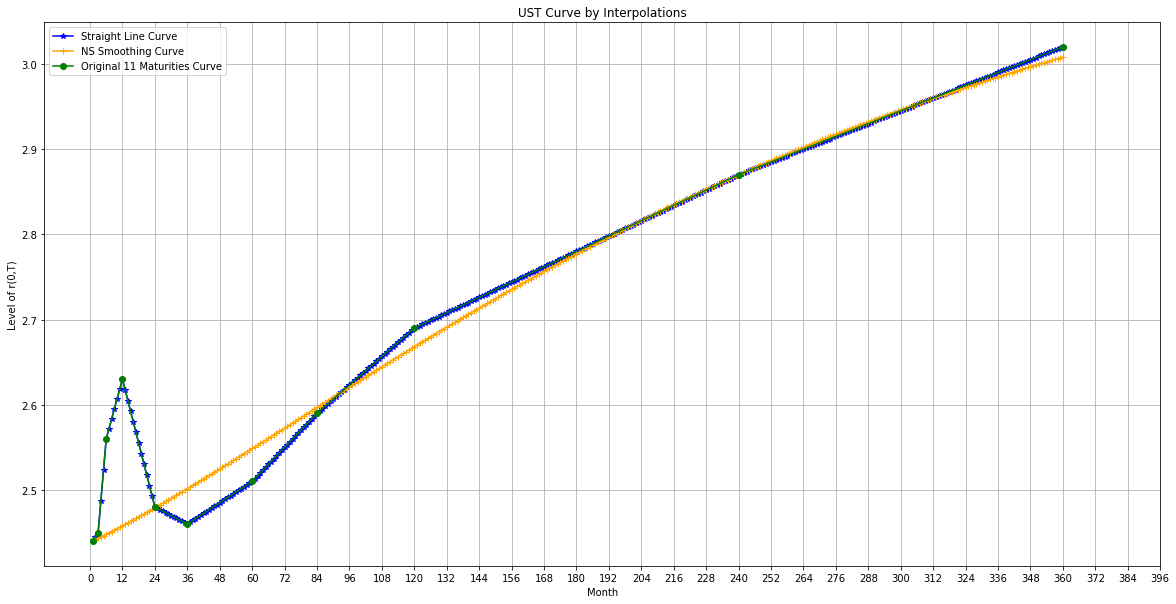

In [14]:
# Plot 
straightLineCurve = np.ndarray.flatten(yieldCurve20181231Interp.values)
NSSmoothCurve = np.array([])
opt_hypothesisNS = [ 3.4202766,  -0.98182687, -0.69221123, 93.86634961]
for t in expectedMonths:
    rate = NSrZeroToT(opt_hypothesisNS, t)
    NSSmoothCurve = np.append(NSSmoothCurve, [rate])
assert len(NSSmoothCurve) == len(straightLineCurve), "Length Different. {} vs. {}".format(len(NSSmoothCurve), len(straightLineCurve))
originalCurve = np.ndarray.flatten(yieldCurve20181231AsMth.values)


fig3 = plt.figure(figsize=(20,10))
ax = plt.axes()
# Curve by straight interpolation
ax.plot(expectedMonths, straightLineCurve, '-*', color='blue', label='Straight Line Curve')
# Curve by NS Smoothing Calculation
ax.plot(expectedMonths, NSSmoothCurve, '-+', color='orange', label='NS Smoothing Curve')
# Curve by 11 original maturities from FRED
ax.plot(months, originalCurve, '-o', color='green', label='Original 11 Maturities Curve')

# ax.set_xticklabels(xTicks)
plt.xticks(np.arange(0, 400, 12))
ax.set_xlabel('Month')
ax.set_ylabel('Level of r(0,T)')
plt.title('UST Curve by Interpolations')
plt.legend()
plt.grid(True)
plt.show()


/Users/erictseng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/Users/erictseng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/Users/erictseng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/Users/erictseng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


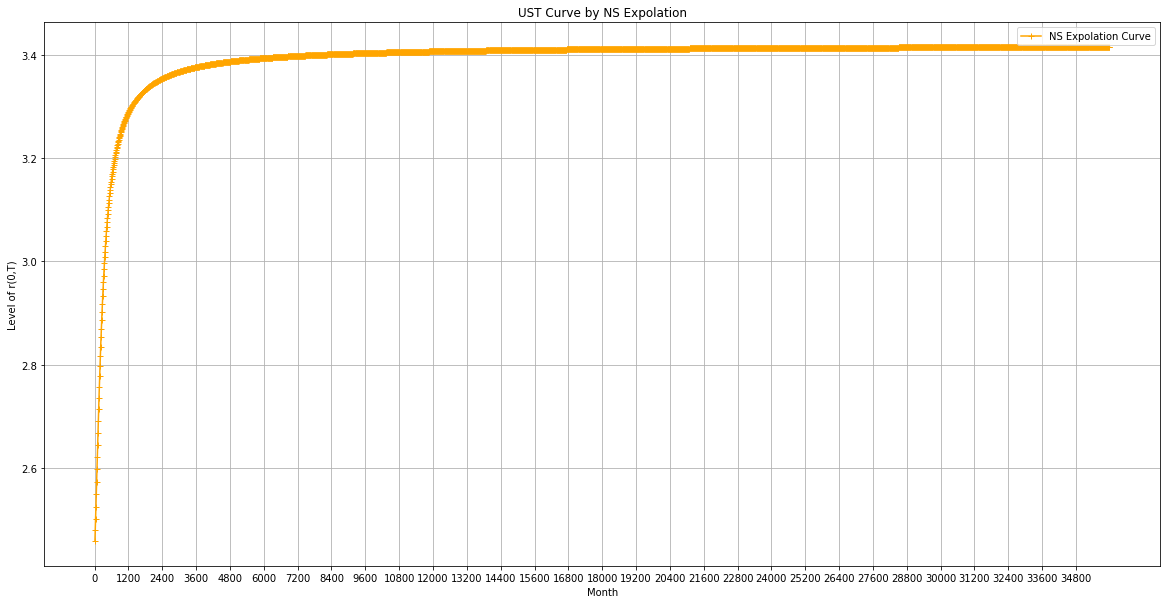

In [15]:
NSextrapolation = np.array([])
extendedMonths = np.arange(0, 36000, 12)
opt_hypothesisNS = [ 3.4202766,  -0.98182687, -0.69221123, 93.86634961]
for t in extendedMonths:
    rate = NSrZeroToT(opt_hypothesisNS, t)
    NSextrapolation = np.append(NSextrapolation, [rate])

fig4 = plt.figure(figsize=(20,10))
ax = plt.axes()
# Curve by NS Extrapolation Calculation
ax.plot(extendedMonths, NSextrapolation, '-+', color='orange', label='NS Expolation Curve')

# ax.set_xticklabels(xTicks)
plt.xticks(np.arange(0, 36000, 1200))
plt.yticks()
ax.set_xlabel('Month')
ax.set_ylabel('Level of r(0,T)')
plt.title('UST Curve by NS Expolation')
plt.legend()
plt.grid(True)
plt.show()


- The Nelson-Siegel curve implies that the perpetual interest rate increases with longer maturity. 
- As the time goes to infinity, $T->\infty$ , all terms except for $\beta_{0}$ approach zero, so $\beta_{0}$ is the yield level at the long end of the curve. In our numerical solution, the yield curve converges to $\beta_{0} = 3.4202766$ 

<div class="alert alert-block alert-danger">
<b>Just don't run:</b> Some PCA Scatter plots for personal trials
</div>

In [16]:
# # Graph the first 3 eigenvectors
# xTicks = ['1mo', '3mo', '6mo', '1y', '2y', '3y', '5y', '7y', '10y', '20y', '30y']
# Xs = np.arange(0, len(seriesnames))

# fig = plt.figure(figsize=(15,7))
# ax = plt.axes()
# ax.plot(Xs, dfPricesSx3PCDiff.PCOne, '-o', color='blue', label='PC1')
# ax.plot(Xs, dfPricesSx3PCDiff.PCTwo, '-o', color='orange', label='PC2')
# ax.plot(Xs, dfPricesSx3PCDiff.PCThree, '-o', color='green', label='PC3')
# # ax.set_xticklabels(xTicks)
# plt.xticks(Xs, xTicks)
# ax.set_xlabel('Tenor')
# ax.set_ylabel('Level')
# plt.title('UST Curve Principle Components')
# plt.legend()
# plt.show()

In [17]:
# # Ref: http://sebastianraschka.com/Articles/2014_pca_step_by_step.html
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import proj3d
# from matplotlib.patches import FancyArrowPatch

# class Arrow3D(FancyArrowPatch):
#     def __init__(self, xs, ys, zs, *args, **kwargs):
#         FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
#         self._verts3d = xs, ys, zs

#     def draw(self, renderer):
#         xs3d, ys3d, zs3d = self._verts3d
#         xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
#         self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
#         FancyArrowPatch.draw(self, renderer)

In [18]:
# # Graph the first 3 eigenvectors
# fig = plt.figure(figsize=(7,7))
# ax = fig.add_subplot(111, projection='3d')
# # Only keep real part for 0j in complex part
# pcx = arrPricesDx3PCDiff[:, 0].reshape(1, 248).real
# pcy = arrPricesDx3PCDiff[:, 1].reshape(1,248).real
# pcz = arrPricesDx3PCDiff[:, 2].reshape(1,248).real
# meanx = np.mean(pcx)
# meany = np.mean(pcy)
# meanz = np.mean(pcz)
# centroid = np.array([meanx, meany, meanz])

# ax.scatter(pcx, pcy, pcz, c='green', marker='o')
# ax.plot([meanx], [meany], [meanz], 'o', markersize=10, color='red', alpha=0.5)
# for v in eigVecs[:, 0:3].T.real:
# #     vStd = (v - np.mean(v)) / np.std(v)
# #     a = Arrow3D([meanx, vStd[0]], [meany, vStd[1]], [meanz, vStd[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
# #     v += centroid
#     a = Arrow3D([meanx, v[0]], [meany, v[1]], [meanz, v[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
#     ax.add_artist(a)
# ax.set_xlabel('1st PC')
# ax.set_ylabel('2nd PC')
# ax.set_zlabel('3rd PC')
# # thre = 0.01
# # ax.set_xbound(-thre, thre)
# # ax.set_ybound(-thre, thre)
# # ax.set_zbound(-thre, thre)


# plt.title('First 3 Principle Components')

# plt.show()
